# Visualize D4RL dataset
* Visualize dataset basic features
* Visualize next_obs to understand termination and timeouts
* Visualize delta_obs to understand dynamics smoothness
* Visualize trajectories

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.nn.utils.rnn import pad_sequence

from src.utils.data import parse_stacked_trajectories

seed = 0

In [3]:
hopper_obs_names = [
    "top-z", "top-angle", "thigh-angle", "leg-angle",
    "foot-angle", "top-x-v", "top-z-v", "top-angle-v",
    "thigh-angle-v", "leg-angle-v", "foot-angle-v"
]

In [4]:
# load data
with open("../data/d4rl/hopper-medium-expert-v2.p", "rb") as f:
    dataset = pickle.load(f)

print("keys:", dataset.keys())

keys: dict_keys(['actions', 'infos/action_log_probs', 'infos/qpos', 'infos/qvel', 'next_observations', 'observations', 'rewards', 'terminals', 'timeouts'])


In [19]:
def parse_stacked_trajectories(data, max_eps=None, skip_terminated=True, obs_mean=None, obs_std=None):
    obs_mean = 0. if obs_mean is None else obs_mean
    obs_std = 1. if obs_std is None else obs_std

    obs = data["observations"]
    act = data["actions"]
    rwd = data["rewards"]
    next_obs = data["next_observations"]
    terminated = data["terminals"]
    timeout = data['timeouts']

    eps_id = np.cumsum(terminated + timeout, axis=0).flatten()
    eps_id = np.insert(eps_id, 0, 0)[:-1] # offset by 1 step
    max_eps = eps_id.max() + 1 if max_eps is None else max_eps

    dataset = []
    for e in np.unique(eps_id):
        if terminated[eps_id == e].sum() > 0 and skip_terminated:
            continue

        dataset.append({
            "obs": (obs[eps_id == e] - obs_mean) / obs_std,
            "act": act[eps_id == e],
            "rwd": rwd[eps_id == e],
            "next_obs": (next_obs[eps_id == e] - obs_mean) / obs_std,
            "done": terminated[eps_id == e] * 1,
        })

        if len(dataset) >= max_eps:
            break
    return dataset

In [14]:
# unpack dataset
obs = dataset["observations"]
act = dataset["actions"]
rwd = dataset["rewards"]
next_obs = dataset["next_observations"]
terminated = dataset["terminals"]
timeout = dataset["timeouts"]

print("data size:", obs.shape, act.shape, rwd.shape, next_obs.shape, terminated.shape, timeout.shape)

print("num terminated:", sum(terminated))
print("num timeout:", sum(timeout))
print("num terminated and timeout:", sum(terminated & timeout))

data size: (1999906, 11) (1999906, 3) (1999906,) (1999906, 11) (1999906,) (1999906,)
num terminated: 2274
num timeout: 939
num terminated and timeout: 0


In [16]:
def collate_fn(batch, pad_value):
    """ Collate batch of dict to have the same sequence length """
    assert isinstance(batch[0], dict)
    keys = list(batch[0].keys())
    pad_batch = {k: pad_sequence([b[k] for b in batch], padding_value=pad_value) for k in keys}
    mask = pad_sequence([torch.ones(len(b[keys[0]])) for b in batch])
    return pad_batch, mask

In [23]:
# reshape dataset into episodes with padding
traj_dataset = parse_stacked_trajectories(
    dataset, max_eps=10
)

traj_dataset_torch = [
    {k: torch.from_numpy(v).to(torch.float32) for k, v in d.items()} 
    for d in traj_dataset
]
pad_dataset, mask = collate_fn(traj_dataset_torch, pad_value=torch.nan)

print("data size", {k:v.shape for k, v in pad_dataset.items()})
print("mask shape", mask.shape)
print("min eps len", mask.sum(0).min(), "max eps len", mask.sum(0).max())

data size {'obs': torch.Size([1000, 10, 11]), 'act': torch.Size([1000, 10, 3]), 'rwd': torch.Size([1000, 10]), 'next_obs': torch.Size([1000, 10, 11]), 'done': torch.Size([1000, 10])}
mask shape torch.Size([1000, 10])
min eps len tensor(1000.) max eps len tensor(1000.)


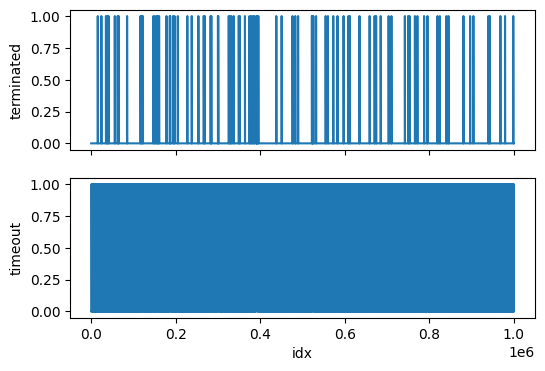

In [23]:
# plot terminate and timeout
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax[0].plot(terminated)
ax[1].plot(timeout)

ax[0].set_ylabel("terminated")
ax[1].set_ylabel("timeout")
ax[1].set_xlabel("idx")
plt.show()

In [29]:
# subsample terminal and non-terminal obs and next_obs
np.random.seed(seed)

idx = np.arange(len(obs))
idx_terminal = idx[terminated == 1]
idx_nonterminal = idx[terminated == 0]
idx_timeout = idx[timeout == 1]
np.random.permutation(idx_terminal)

num_samples = 3000
idx_nonterminal = idx_nonterminal[:num_samples]

obs_nonterminal = obs[idx_nonterminal]
obs_terminal = obs[idx_terminal]
obs_trunc = obs[idx_timeout]

next_obs_nonterminal = next_obs[idx_nonterminal]
next_obs_terminal = next_obs[idx_terminal]
next_obs_trunc = next_obs[idx_timeout]

print("nonterminal sample size", obs_nonterminal.shape, next_obs_nonterminal.shape)
print("terminal sample size", obs_terminal.shape,  next_obs_terminal.shape)
print("timeout sample size", obs_trunc.shape, next_obs_trunc.shape)

nonterminal sample size (3000, 11) (3000, 11)
terminal sample size (2274, 11) (2274, 11)
timeout sample size (939, 11) (939, 11)


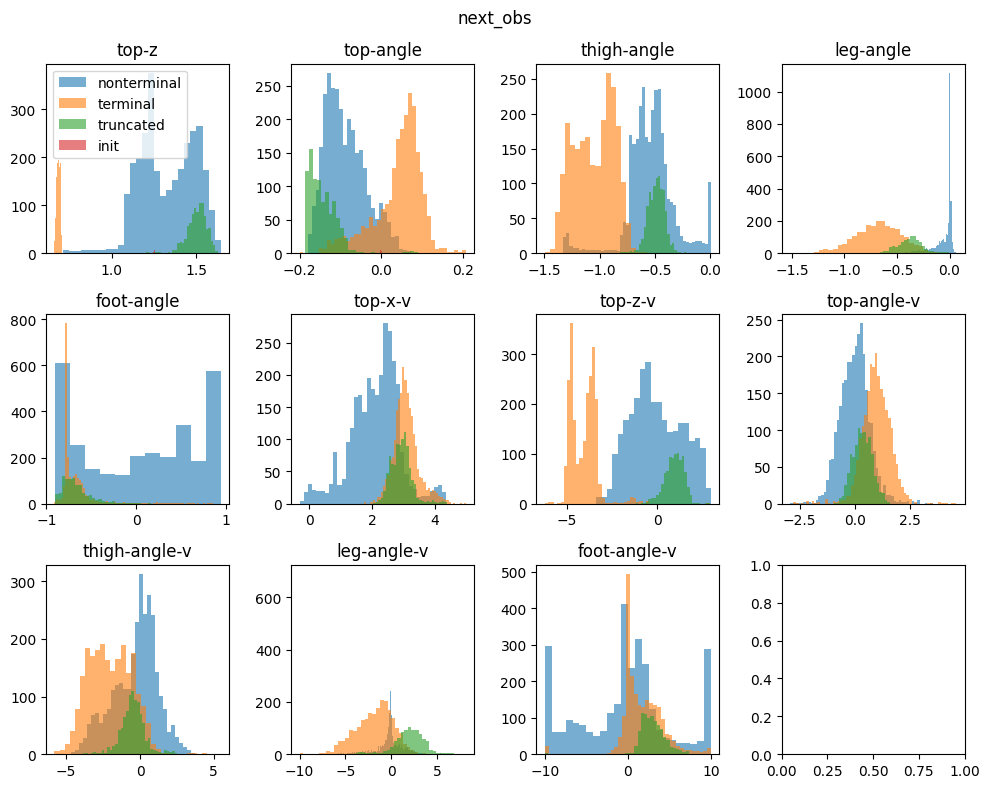

In [27]:
# plot next_obs histograms
fig, ax = plt.subplots(3, 4, figsize=(10, 8))
ax = ax.flat
for i in range(obs.shape[1]):
    ax[i].hist(next_obs_nonterminal[:, i], bins="fd", alpha=0.6, label="nonterminal")
    ax[i].hist(next_obs_terminal[:, i], bins="fd", alpha=0.6, label="terminal")
    ax[i].hist(next_obs_trunc[:, i], bins="fd", alpha=0.6, label="truncated")
    ax[i].hist(pad_dataset["obs"][0, :, i], bins="fd", alpha=0.6, label="init")
    ax[i].set_title(hopper_obs_names[i])

ax[0].legend()
plt.suptitle("next_obs")
plt.tight_layout()
plt.show()

In [30]:
# compute normalized obs delta
obs_mean = obs.mean(0)
obs_std = obs.std(0)

def normalize(x):
    return (x - obs_mean) / obs_std

delta_obs_nonterminal = normalize(next_obs_nonterminal) - normalize(obs_nonterminal)
delta_obs_terminal = normalize(next_obs_terminal) - normalize(obs_terminal)
delta_obs_trunc = normalize(next_obs_trunc) - normalize(obs_trunc)

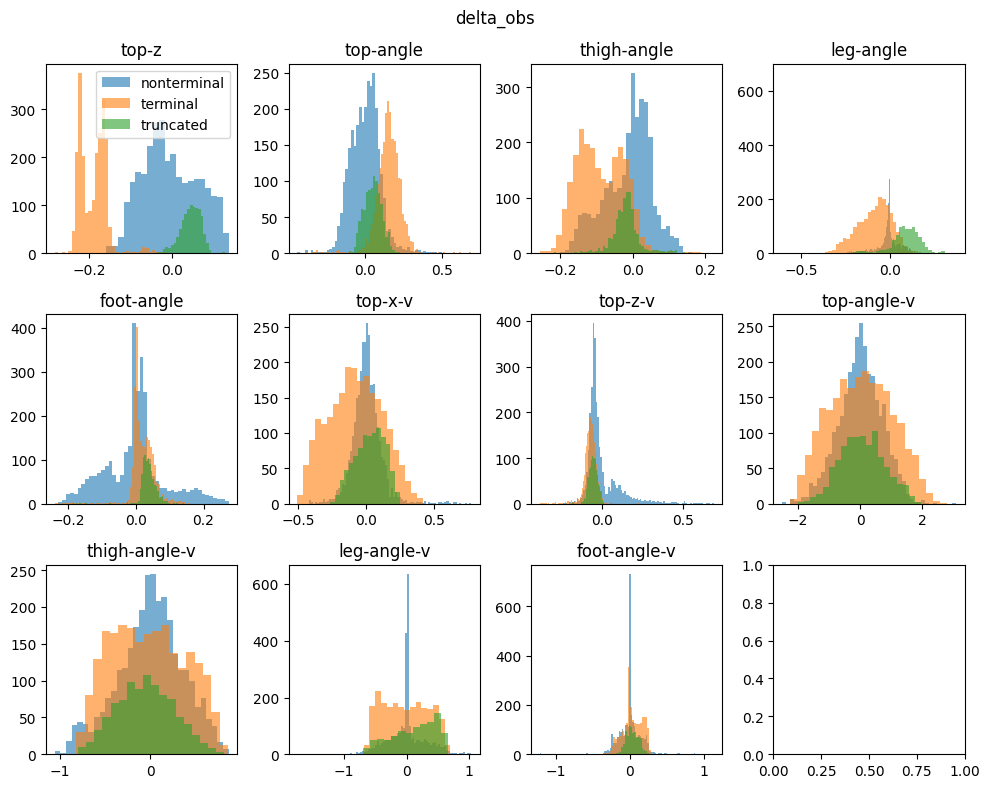

In [31]:
# plot delta_obs histograms
fig, ax = plt.subplots(3, 4, figsize=(10, 8))
ax = ax.flat
for i in range(obs.shape[1]):
    ax[i].hist(delta_obs_nonterminal[:, i], bins="fd", alpha=0.6, label="nonterminal")
    ax[i].hist(delta_obs_terminal[:, i], bins="fd", alpha=0.6, label="terminal")
    ax[i].hist(delta_obs_trunc[:, i], bins="fd", alpha=0.6, label="truncated")
    ax[i].set_title(hopper_obs_names[i])

ax[0].legend()
plt.suptitle("delta_obs")
plt.tight_layout()
plt.show()

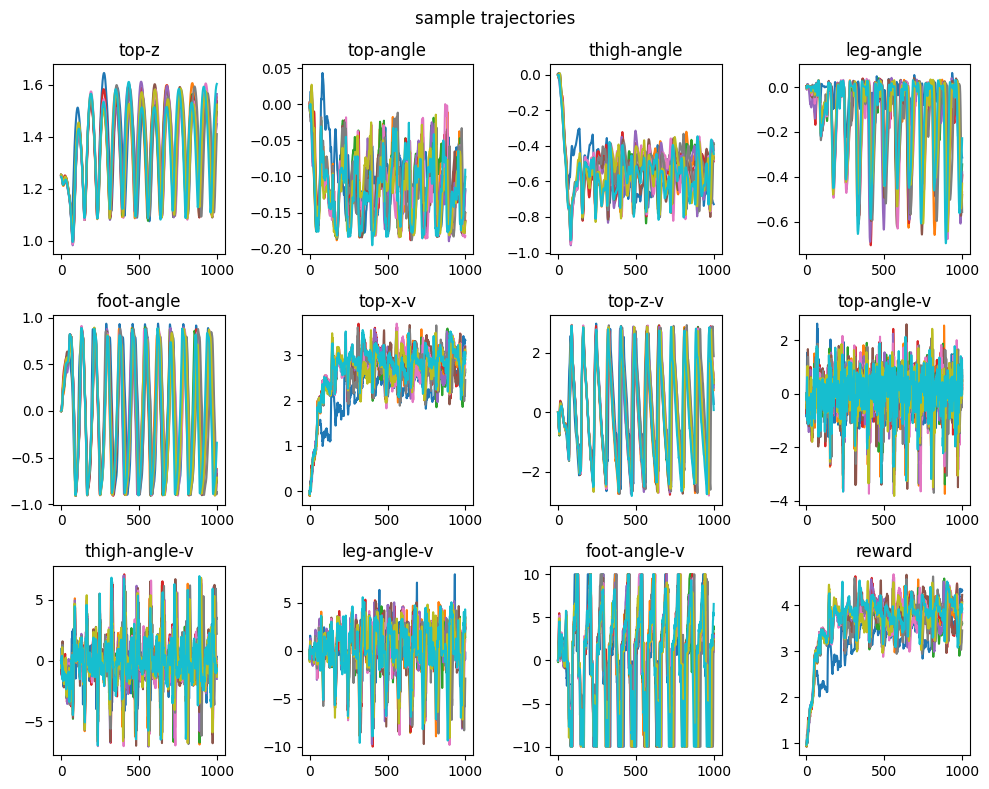

In [41]:
# plot a batch of trajectories
batch_size = 10
idx = np.arange(mask.shape[1])
np.random.permutation(idx)
idx = idx[:batch_size]

fig, ax = plt.subplots(3, 4, figsize=(10, 8))
ax = ax.flat
for i in range(obs.shape[1]):
    ax[i].plot(pad_dataset["obs"][:, idx, i])
    ax[i].set_title(hopper_obs_names[i])

ax[-1].plot(pad_dataset["rwd"][:, idx])
ax[-1].set_title("reward")
plt.suptitle("sample trajectories")
plt.tight_layout()
plt.show()